# Laboratorio 2: Análisis Exploratorio y Curación de Datos

> **Análisis de las Posiciones del Aborto en Twitter**
> *Diplomatura en Ciencias de Datos, Aprendizaje Automático y sus aplicaciones.*
> *Integrantes: 
    - Carlos Piaggio
    - Juan Pablo Analian


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy 
from scipy import stats

import random, string
from PIL import Image #pillow library (wordcloud)
import sys
%matplotlib inline

#https://www.datacamp.com/community/tutorials/wordcloud-python
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator 

### Cargamos los datasets originales

In [2]:
df_users_junio =  pd.read_csv('data/users_junio.csv', parse_dates=['created_at'])
df_users_agosto =  pd.read_csv('data/users_agosto.csv', parse_dates=['created_at'])

df_tweets_junio =  pd.read_csv('data/tweets_junio.csv', parse_dates=['created_at'])
df_tweets_agosto =  pd.read_csv('data/tweets_agosto.csv', parse_dates=['created_at'])

In [83]:
df_tweets_agosto.head(5)

,id,created_at,favorite_count,retweet_count,text,favorited,retweeted,user_name,user_id,original_id
0,1025181421961392135,2018-08-03 00:47:52+00:00,0,0,🔹 5 Mitos sobre el aborto que todos debemos sa...,False,False,Revista Digital,2208347839,1025181421961392135
1,1025181422347268097,2018-08-03 00:47:52+00:00,0,0,RT @antotripelli: Mi mamá hablando con una ami...,False,False,Mimi,878157175,1025181422347268097
2,1025181423639113728,2018-08-03 00:47:53+00:00,0,0,El aborto que se perdió tu vieja jajajajajajaj...,False,False,Delfina💚,984930721373573120,1025181423639113728
3,1025181426361221120,2018-08-03 00:47:53+00:00,0,0,RT @cortalabochx: Si se legaliza el aborto los...,False,False,Mr. Drama👑,630668646,1025181426361221120
4,1025181426608730113,2018-08-03 00:47:53+00:00,0,0,RT @AgustinLajeQuot: Ya saben que responder cu...,False,False,Luigi Venegas,403723840,1025181426608730113


### Extraemos los hashtags
Evaluamos la siguiente funcion (estractall, con expresion regular) para extraer los hashtags de los textos de cada tweet.

In [4]:
df_tweets_agosto.text.str.extractall(r'(\#\w+)')[0:10]

0
   match                          
12 0                    #QueSeaLey
   1                  #AbortoLegal
   2                           #8A
   3      #EstamosHaciendoHistoria
18 0             #TucumanEsProvida
   1        #NoAlAbortoEnArgentina
19 0                           #8A
   1               #SeamosMillones
   2                  #AbortoLegal
   3                     #LuzVerde

In [5]:
df_tweets_agosto.iloc[12,4]

'RT @mromero64: Sororidad. De eso se trata. #QueSeaLey #AbortoLegal #8A @CampAbortoLegal #EstamosHaciendoHistoria @PorAbortoLegal @Redpspv @…'

#### Unimos los 2 datasets de tweets (junio y agost) para extraer los hashtags a considerar

In [4]:
df_hashtags_temp = pd.concat( [df_tweets_junio.full_text.str.extractall(r'(\#\w+)').reset_index(drop=True)[0] ,
                               df_tweets_agosto.text.str.extractall(r'(\#\w+)').reset_index(drop=True)[0] ]).to_frame()
                
df_hashtags_temp.columns = ['hashtag']

In [85]:
# los pasamos a minúscula para poder contabilizar los mas usados de forma correcta.
df_hashtags_temp['hashtag_lower'] = df_hashtags_temp['hashtag'].str.lower()
df_hashtags_temp.head()

,hashtag,hashtag_lower
0,#NoVotenContraLas,#novotencontralas
1,#NoVotenContraLasMujeres,#novotencontralasmujeres
2,#AbortoLegalYA,#abortolegalya
3,#abortolegalya,#abortolegalya
4,#13JAbortoLegal,#13jabortolegal


In [6]:
#vemos las cantidades de los HT mas usados
df_hashtags_temp['hashtag_lower'].value_counts()[0:10]

#abortolegalya            264173
#abortolegal               68978
#quesealey                 55693
#abortoseraley             51359
#salvemoslas2vidas         46613
#argentinaesprovida        46116
#noalabortoenargentina     36206
#abortosesionhistorica     35485
#queelabortosealey         34681
#noalaborto                21573
Name: hashtag_lower, dtype: int64

#### Bajamos a un CSV los hashtags con su frecuencia, ordenados de mayor a menor.
con un trabajo manual (agregando una nueva columna 'posicion'), hemos categorizado los hashtags mas frecuentes, con la condición de que representen mas del 90% de la cantidad de tweets que los contengan.

In [7]:
df_conteo = df_hashtags_temp['hashtag_lower'].value_counts().to_frame()
df_conteo.columns = ['cantidad_de_veces'] 
df_conteo.index.names = ['hashtag']
df_conteo["cumpercentage"] = df_conteo['cantidad_de_veces'].cumsum() / df_conteo['cantidad_de_veces'].sum() * 100

df_conteo.to_csv('./out/hashtags.csv')

#### Volvemos a cargar el CSV con la nueva columna

In [8]:
hashtags = pd.read_csv('./In/hashtags_clasificados.csv')    
hashtags[hashtags.posicion.isnull() == False].head()

,hashtag,cantidad_de_veces,cumpercentage,posicion
0,#abortolegalya,264173,24.124287,1.0
1,#abortolegal,68978,30.423360,1.0
2,#quesealey,55693,35.509246,1.0
3,#abortoseraley,51359,40.199352,1.0
4,#salvemoslas2vidas,46613,44.456052,-1.0


## Tweets de Agosto
### agrupamos por cada tweet, sus hashtags para luego identificar a que posición pertenecen
(tambien los pasamos a minúscula para poder hacer coincidir con el "maestro de hashtags")

In [9]:
df_ta_clasificado = df_tweets_agosto.text.str.extractall(r'(\#\w+)')
df_ta_clasificado.columns = ['hashtag']
df_ta_clasificado.index.names = ['id','match']
df_ta_clasificado['hashtag_lower'] = df_ta_clasificado['hashtag'].str.lower()
df_ta_clasificado.head(8) 

hashtag             hashtag_lower
id match                                                    
12 0                    #QueSeaLey                #quesealey
   1                  #AbortoLegal              #abortolegal
   2                           #8A                       #8a
   3      #EstamosHaciendoHistoria  #estamoshaciendohistoria
18 0             #TucumanEsProvida         #tucumanesprovida
   1        #NoAlAbortoEnArgentina    #noalabortoenargentina
19 0                           #8A                       #8a
   1               #SeamosMillones           #seamosmillones

In [10]:
lista_afavor =  hashtags[hashtags.posicion == 1].hashtag.tolist()
lista_encontra =  hashtags[hashtags.posicion == -1].hashtag.tolist()

def clasificador_pos(row):
    if row['hashtag_lower'] in lista_afavor:
        return 1
    elif row['hashtag_lower'] in lista_encontra:
        return -1
    else:
        return 0    

In [11]:
df_ta_clasificado['posicion'] = df_ta_clasificado.apply(clasificador_pos, axis=1)

In [12]:
df_ta_clasificado.head(12)

hashtag             hashtag_lower  posicion
id match                                                              
12 0                    #QueSeaLey                #quesealey         1
   1                  #AbortoLegal              #abortolegal         1
   2                           #8A                       #8a         0
   3      #EstamosHaciendoHistoria  #estamoshaciendohistoria         1
18 0             #TucumanEsProvida         #tucumanesprovida         0
   1        #NoAlAbortoEnArgentina    #noalabortoenargentina        -1
19 0                           #8A                       #8a         0
   1               #SeamosMillones           #seamosmillones         0
   2                  #AbortoLegal              #abortolegal         1
   3                     #LuzVerde                 #luzverde         0
20 0                  #AbortoLegal              #abortolegal         1
26 0          #SalvemosLasDosVidas      #salvemoslasdosvidas        -1

In [13]:
df_sum_afavor = df_ta_clasificado[df_ta_clasificado.posicion == 1].groupby('id').agg({'posicion':'sum'})
df_sum_afavor.columns = ['q_ht_a_favor']

df_sum_encontra = df_ta_clasificado[df_ta_clasificado.posicion == -1].groupby('id').agg({'posicion':'sum'})
df_sum_encontra['posicion'] = df_sum_encontra['posicion'] * -1
df_sum_encontra.columns = ['q_ht_en_contra']

df_sum_nocat = df_ta_clasificado[df_ta_clasificado.posicion == 0].groupby('id').agg({'posicion':'count'})
df_sum_nocat.columns = ['q_ht_no_cat']

In [14]:
 df_sum_afavor.head(5)

,q_ht_a_favor
id,
12,3
19,1
20,1
32,1
50,2


In [15]:
df_tweets_agosto_tmp1 = pd.merge(df_tweets_agosto, df_sum_afavor, how ='left', left_index=True, right_index=True)
df_tweets_agosto_tmp2 = pd.merge(df_tweets_agosto_tmp1, df_sum_encontra, how ='left', left_index=True, right_index=True)
df_tweets_agosto_tmp3 = pd.merge(df_tweets_agosto_tmp2, df_sum_nocat, how ='left', left_index=True, right_index=True)

## Tweets de Junio
### Lo mismo aplicamos para el DS de Junio de tweets


In [16]:
df_tj_clasificado = df_tweets_junio.full_text.str.extractall(r'(\#\w+)')
df_tj_clasificado.columns = ['hashtag']
df_tj_clasificado.index.names = ['id','match']
df_tj_clasificado['hashtag_lower'] = df_tj_clasificado['hashtag'].str.lower()
df_tj_clasificado.head(8) 

hashtag             hashtag_lower
id match                                                    
0  0             #NoVotenContraLas         #novotencontralas
2  0      #NoVotenContraLasMujeres  #novotencontralasmujeres
   1                #AbortoLegalYA            #abortolegalya
3  0                #abortolegalya            #abortolegalya
   1               #13JAbortoLegal           #13jabortolegal
4  0          #Salvemoslasdosvidas      #salvemoslasdosvidas
6  0      #NoVotenContraLasMujeres  #novotencontralasmujeres
7  0      #NoVotenContraLasMujeres  #novotencontralasmujeres

In [17]:
df_tj_clasificado['posicion'] = df_tj_clasificado.apply(clasificador_pos, axis=1)

In [18]:
df_tj_clasificado.head(10)

hashtag             hashtag_lower  posicion
id match                                                              
0  0             #NoVotenContraLas         #novotencontralas         1
2  0      #NoVotenContraLasMujeres  #novotencontralasmujeres         1
   1                #AbortoLegalYA            #abortolegalya         1
3  0                #abortolegalya            #abortolegalya         1
   1               #13JAbortoLegal           #13jabortolegal         1
4  0          #Salvemoslasdosvidas      #salvemoslasdosvidas        -1
6  0      #NoVotenContraLasMujeres  #novotencontralasmujeres         1
7  0      #NoVotenContraLasMujeres  #novotencontralasmujeres         1
   1               #13JAbortoLegal           #13jabortolegal         1
   2                #AbortoLegalYa            #abortolegalya         1

In [19]:
df_sum_afavor_junio = df_tj_clasificado[df_tj_clasificado.posicion == 1].groupby('id').agg({'posicion':'sum'})
df_sum_afavor_junio.columns = ['q_ht_a_favor']

df_sum_encontra_junio = df_tj_clasificado[df_tj_clasificado.posicion == -1].groupby('id').agg({'posicion':'sum'})
df_sum_encontra_junio['posicion'] = df_sum_encontra_junio['posicion'] * -1
df_sum_encontra_junio.columns = ['q_ht_en_contra']

df_sum_nocat_junio = df_tj_clasificado[df_tj_clasificado.posicion == 0].groupby('id').agg({'posicion':'count'})
df_sum_nocat_junio.columns = ['q_ht_no_cat']

In [20]:
df_sum_encontra_junio.head(5)

,q_ht_en_contra
id,
4,1
60,1
75,2
179,2
253,1


In [21]:
df_tweets_junio_tmp1 = pd.merge(df_tweets_junio, df_sum_afavor_junio, how ='left', left_index=True, right_index=True)
df_tweets_junio_tmp2 = pd.merge(df_tweets_junio_tmp1, df_sum_encontra_junio, how ='left', left_index=True, right_index=True)
df_tweets_junio_tmp3 = pd.merge(df_tweets_junio_tmp2, df_sum_nocat_junio, how ='left', left_index=True, right_index=True)


### A este punto, tenemos los  dataframe "df_tweets_agosto_tmp3"  y "df_tweets_junio_tmp3" con las 3 columnas que indican cantidad de hashtags a favor, en contra y no definidos.
Vemos un ejemplo con datos de junio

In [86]:
df_tweets_junio_tmp3.head(5)

,id,created_at,favorite_count,retweet_count,full_text,posicion,favorited,retweeted,user_name,user_id,original_id,q_ht_a_favor,q_ht_en_contra,q_ht_no_cat,real_retweet_count
0,1005600427080110080,2018-06-09 23:59:59+00:00,0,14,RT @PTSarg: Contamos con una ventaja que ellos...,si,False,False,Luciana HL,3130302891,1005600427080110080,1.0,NaN,NaN,0
1,1005600422772527105,2018-06-09 23:59:58+00:00,0,59,RT @juanabalmedina: Excelentes reflexiones de ...,si,False,False,Oriana Ribeiro,383350997,1005600422772527105,NaN,NaN,NaN,0
2,1005600422269243397,2018-06-09 23:59:58+00:00,2,0,En el fondo lo que les jode es nuestra liberta...,si,False,False,Luz Scarpati,2999619141,1005600422269243397,2.0,NaN,NaN,0
3,1005600416862801921,2018-06-09 23:59:57+00:00,0,0,holla! me gustaría q ayuden a esta junta d fir...,si,False,False,gigi not hadid,3668114236,1005600416862801921,2.0,NaN,NaN,0
4,1005600413838692352,2018-06-09 23:59:56+00:00,0,308,RT @femialborto: A vos que decís #Salvemoslasd...,si,False,False,niña de tilcara🌰,828222093804371968,1005600413838692352,NaN,1.0,NaN,0


### Corrección de datos: vamos a contabilizar los verdaderos retweets, en una nueva columna.

In [23]:
#si un usuario hace RT sobre un tweet original, este tweet que se lista como si fuera de este usuario, trae indicadores del tweet original.
#los datos mas representativos son los retweet_count. Ya que los favorite_count de estos mensajes, son pocos y no relevantes.

def contador_de_retweets(texto, retweet_count):
    if texto.startswith('RT @'):
        return 0    
    else:
        return retweet_count
    

In [24]:
#el Dataframe de agosto (df_tweets_agost), tiene todos los valroes de retweet_count en 0. 
df_tweets_agosto_tmp3['real_retweet_count'] = 0 #df_tweets_agosto_tmp3.apply(lambda row : contador_de_retweets(row['text'],row['retweet_count']), axis = 1) 

In [25]:
df_tweets_junio_tmp3['real_retweet_count'] = df_tweets_junio_tmp3.apply(lambda row : contador_de_retweets(row['full_text'],row['retweet_count']), axis = 1) 

### Aplicamos una sumarizacion por user_id en cada uno de los dataframe de tweets de cada mes

In [26]:
df_tweets_agosto_sum = df_tweets_agosto_tmp3.groupby(['user_id']).agg({'favorite_count':'sum', 'real_retweet_count': 'sum','id': 'count', 'q_ht_a_favor':'sum','q_ht_en_contra':'sum','q_ht_no_cat':'sum'}).reset_index().rename(columns={'id':'tweets'})
df_tweets_junio_sum = df_tweets_junio_tmp3.groupby(['user_id']).agg({'favorite_count':'sum', 'real_retweet_count': 'sum','id': 'count', 'q_ht_a_favor':'sum','q_ht_en_contra':'sum','q_ht_no_cat':'sum'}).reset_index().rename(columns={'id':'tweets'})

In [27]:
print("Filas y columnas")
print("junio:" , df_tweets_junio_sum.shape)
print("agosto:" , df_tweets_agosto_sum.shape)

Filas y columnas
junio: (329782, 7)
agosto: (74324, 7)


### Unimos los dos dataframes sumarizados

In [28]:
df_tweets_sum = pd.concat([df_tweets_junio_sum, df_tweets_agosto_sum]) 

#### Controlamos como será la sumarizacion de los 2 datasets de tweets por user_id
Primero buscamos los duplicados, (usuarios que hayan tweeteado en junio y agosto), tomamos 1 como muestra y aplicamos el agrupamiento para ver sus valores.

In [29]:
#df_tweets_sum.groupby(['user_id']).agg({'user_id':'count'}).rename(columns={'user_id':'cantidad'}).sort_values('cantidad', axis=0, ascending=0).head(10)
df_tweets_sum[df_tweets_sum.user_id == 443377811]

,user_id,favorite_count,real_retweet_count,tweets,q_ht_a_favor,q_ht_en_contra,q_ht_no_cat
106630,443377811,2,0,1,1.0,0.0,0.0
22764,443377811,0,0,5,1.0,0.0,2.0


In [30]:
df_tweets_sum[df_tweets_sum.user_id == 443377811].groupby(['user_id']).agg({'favorite_count':'sum','real_retweet_count':'sum', 'tweets':'sum', 'q_ht_a_favor':'sum','q_ht_en_contra':'sum','q_ht_no_cat':'sum'})

,favorite_count,real_retweet_count,tweets,q_ht_a_favor,q_ht_en_contra,q_ht_no_cat
user_id,,,,,,
443377811,2,0,6,2.0,0.0,2.0


### Volvemos a sumarizar el DF df_tweets_sum
####  Agrupamos (y sumarizamos) los registros de un mismo usuario (que haya estado tweeteando en junio y agosto)

In [31]:
df_tweets = df_tweets_sum.groupby(['user_id']).agg({'favorite_count':'sum','real_retweet_count':'sum', 'tweets':'sum', 'q_ht_a_favor':'sum','q_ht_en_contra':'sum','q_ht_no_cat':'sum'})

In [32]:
df_tweets.head(10)

,favorite_count,real_retweet_count,tweets,q_ht_a_favor,q_ht_en_contra,q_ht_no_cat
user_id,,,,,,
3971,0,0,1,0.0,0.0,0.0
7120,0,0,1,0.0,0.0,0.0
13283,0,0,2,0.0,0.0,0.0
608563,0,0,1,1.0,0.0,0.0
624143,0,0,1,1.0,0.0,0.0
638813,0,0,1,1.0,0.0,0.0
719413,1,0,1,2.0,0.0,0.0
731573,13,8,4,7.0,0.0,1.0
755340,1,0,4,5.0,0.0,0.0


### Unimos los datasets de usuarios originales en uno solo

In [33]:
df_users = pd.concat([df_users_junio, df_users_agosto]).drop_duplicates(subset='id').reset_index(drop=True)

In [34]:
df_users.head(5)

,screen_name,location,followers_count,statuses_count,description,friends_count,favourites_count,created_at,id,name,verified
0,beautyinarose,"Escalada casi Banfield,Bs As",427,50613,"Taladrista por adopción, pero ya en la sangre....",791,10199,2009-01-23 15:38:24+00:00,19398656,Jules Caccaglio,False
1,DanielMort_,"Celaya, Guanajuato",722,18823,~ Admin de @DeditosHelp & Mod de @dedreviil ~ ...,178,13596,2016-10-28 03:17:25+00:00,791841268879851520,DanielMort_ 🗡,False
2,VioleGallotti98,"Córdoba, Argentina",1390,6576,Bariloche ‘15.,1107,13425,2014-07-25 18:07:57+00:00,2680160258,νισlєтα gαllσттι,False
3,Lucia_Achigar,Montevideo,631,3130,Fan de las versalitas.,876,11690,2011-03-04 00:15:24+00:00,260492029,Lucía Achigar 💚,False
4,florgimenezc,"Córdoba, Argentina",1174,25947,Veintitrés del cuatro del noventa y seis. Dere...,360,9978,2012-05-08 16:59:21+00:00,574707030,peto,False


In [35]:
df_users[['id','name','verified','created_at','followers_count','friends_count','statuses_count','favourites_count']].head(5)

,id,name,verified,created_at,followers_count,friends_count,statuses_count,favourites_count
0,19398656,Jules Caccaglio,False,2009-01-23 15:38:24+00:00,427,791,50613,10199
1,791841268879851520,DanielMort_ 🗡,False,2016-10-28 03:17:25+00:00,722,178,18823,13596
2,2680160258,νισlєтα gαllσттι,False,2014-07-25 18:07:57+00:00,1390,1107,6576,13425
3,260492029,Lucía Achigar 💚,False,2011-03-04 00:15:24+00:00,631,876,3130,11690
4,574707030,peto,False,2012-05-08 16:59:21+00:00,1174,360,25947,9978


### Armamos un primer DS final, con un merge del DF original de usuarios + DF sumarizado de tweets

In [44]:
df_final_tmp01 = pd.merge(df_users[['id','name','verified','created_at','followers_count','friends_count','statuses_count','favourites_count']],
                    df_tweets,left_on = 'id', right_on = 'user_id')  
df_final_tmp01.set_index('id')
df_final_tmp01.head(5)

,id,name,verified,created_at,followers_count,friends_count,statuses_count,favourites_count,favorite_count,real_retweet_count,tweets,q_ht_a_favor,q_ht_en_contra,q_ht_no_cat
0,19398656,Jules Caccaglio,False,2009-01-23 15:38:24+00:00,427,791,50613,10199,1,0,9,5.0,0.0,0.0
1,791841268879851520,DanielMort_ 🗡,False,2016-10-28 03:17:25+00:00,722,178,18823,13596,0,0,1,0.0,1.0,0.0
2,2680160258,νισlєтα gαllσттι,False,2014-07-25 18:07:57+00:00,1390,1107,6576,13425,0,0,1,0.0,0.0,0.0
3,260492029,Lucía Achigar 💚,False,2011-03-04 00:15:24+00:00,631,876,3130,11690,2,0,1,1.0,0.0,0.0
4,574707030,peto,False,2012-05-08 16:59:21+00:00,1174,360,25947,9978,0,0,7,4.0,0.0,0.0


#### Controlamos que no haya duplicidad de indices 

In [45]:
df_final_tmp01[df_final_tmp01.duplicated()].shape[0]

0

#### Verificamos valores faltantes

In [46]:
df_final_tmp01.isnull().sum()

id                     0
name                  26
verified               0
created_at             0
followers_count        0
friends_count          0
statuses_count         0
favourites_count       0
favorite_count         0
real_retweet_count     0
tweets                 0
q_ht_a_favor           0
q_ht_en_contra         0
q_ht_no_cat            0
dtype: int64

In [47]:
#vemos la relevancia de estos 26 registros si nombre. (para ver si los descartamos o si les asignamos un valor random)
df_final_tmp01[df_final_tmp01.name.isnull()].head(5)

,id,name,verified,created_at,followers_count,friends_count,statuses_count,favourites_count,favorite_count,real_retweet_count,tweets,q_ht_a_favor,q_ht_en_contra,q_ht_no_cat
16546,995740739211546624,NaN,False,2018-05-13 19:01:07+00:00,1,13,36,28,0,0,3,1.0,0.0,0.0
22689,996000987792969729,NaN,False,2018-05-14 12:15:15+00:00,0,0,1,0,0,0,1,0.0,0.0,0.0
50592,2897572821,NaN,False,2014-11-29 16:06:24+00:00,551,457,12568,2315,0,0,1,1.0,0.0,0.0
72969,994979905883566080,NaN,False,2018-05-11 16:37:50+00:00,0,33,9,1,0,0,1,1.0,0.0,0.0
124573,995442193614692352,NaN,False,2018-05-12 23:14:48+00:00,7,68,24,79,0,0,7,1.0,7.0,1.0


In [128]:
df_final_tmp01[df_final_tmp01.name.isnull()].dtypes

id                                  int64
name                               object
verified                             bool
created_at            datetime64[ns, UTC]
followers_count                     int64
friends_count                       int64
statuses_count                      int64
favourites_count                    int64
favorite_count                      int64
real_retweet_count                  int64
tweets                              int64
q_ht_a_favor                      float64
q_ht_en_contra                    float64
q_ht_no_cat                       float64
dtype: object

In [40]:
#proponemos asignarles valores hash a estos usuarios sin "name", para: 
# 1.- tratar los valores faltantes
# 2.-  posibilitar el paso posterior en donde aplicaremos una técnica para anonimizar uno de los datos.

df_final_tmp01.loc[df_final_tmp01.name.isnull(),'name'] = ''.join(random.choices(string.ascii_letters + string.digits, k=16))   

In [41]:
#verificamos si ha cambiado el "name" del 1er registro (que hemos listado antes de aplicar la funcion)
df_final_tmp01[df_final_tmp01.id == 995740739211546624]

,id,name,verified,created_at,followers_count,friends_count,statuses_count,favourites_count,favorite_count,real_retweet_count,tweets,q_ht_a_favor,q_ht_en_contra,q_ht_no_cat
16546,995740739211546624,jP2f8UtWqsetijP4,False,2018-05-13 19:01:07+00:00,1,13,36,28,0,0,3,1.0,0.0,0.0


### Próximo paso, despersonalizar datos > columna 'name'

In [48]:
from hashlib import md5

def hashit(val):
    if isinstance(val, float): 
        return str(val)
    return md5(val.encode('utf-8')).hexdigest()

In [50]:
df_final_tmp01['hashed_name'] = df_final_tmp01['name'].apply(hashit)

In [52]:
df_final_tmp01[['id','name','hashed_name']].head(7)

,id,name,hashed_name
0,19398656,Jules Caccaglio,d5172b6972ac058149c18f43b85b0c65
1,791841268879851520,DanielMort_ 🗡,a977df035bf9ac28b4ec811a03427fd4
2,2680160258,νισlєтα gαllσттι,70fbe6e143195028b48a0f997d25c941
3,260492029,Lucía Achigar 💚,0a1b84dcf42fd3371b6d9de79c84295f
4,574707030,peto,489539e42b7ecdfee7d4caaf492891e2
5,785234448555966465,Daniel Dimas,b871f8c3d20840828aac71e6852558b0
6,264474243,Berny,31f51f17019e5447c9df156f17432909


In [54]:
df_final_tmp01['posicion_dif'] = df_final_tmp01['q_ht_a_favor'] - df_final_tmp01['q_ht_en_contra']

In [55]:
df_final_tmp01[['id','name','q_ht_a_favor','q_ht_en_contra','posicion_dif']].head(7)

,id,name,q_ht_a_favor,q_ht_en_contra,posicion_dif
0,19398656,Jules Caccaglio,5.0,0.0,5.0
1,791841268879851520,DanielMort_ 🗡,0.0,1.0,-1.0
2,2680160258,νισlєтα gαllσттι,0.0,0.0,0.0
3,260492029,Lucía Achigar 💚,1.0,0.0,1.0
4,574707030,peto,4.0,0.0,4.0
5,785234448555966465,Daniel Dimas,1.0,1.0,0.0
6,264474243,Berny,0.0,1.0,-1.0


In [58]:
def posicion(row):
    if row['q_ht_a_favor'] >  row['q_ht_en_contra']:
        return 'a favor'
    elif row['q_ht_a_favor'] <  row['q_ht_en_contra']:
        return 'en contra'
    else:
        return 'indefinido'    

### Aquí se arma la columna que indica la posición del usuario sobre el proyecto de despenalización

In [59]:
df_final_tmp01['posicion'] = df_final_tmp01.apply(posicion, axis=1)

In [60]:
#verificamos el resultado de la funcion aplicada!
df_final_tmp01[['id','name','q_ht_a_favor','q_ht_en_contra','posicion_dif','posicion']].head(7)

,id,name,q_ht_a_favor,q_ht_en_contra,posicion_dif,posicion
0,19398656,Jules Caccaglio,5.0,0.0,5.0,a favor
1,791841268879851520,DanielMort_ 🗡,0.0,1.0,-1.0,en contra
2,2680160258,νισlєтα gαllσттι,0.0,0.0,0.0,indefinido
3,260492029,Lucía Achigar 💚,1.0,0.0,1.0,a favor
4,574707030,peto,4.0,0.0,4.0,a favor
5,785234448555966465,Daniel Dimas,1.0,1.0,0.0,indefinido
6,264474243,Berny,0.0,1.0,-1.0,en contra


### En un gráfico, vemos claramente la cantidad de usuarios segun la posicion sobre la ley

Text(0.5, 0, 'posicion')

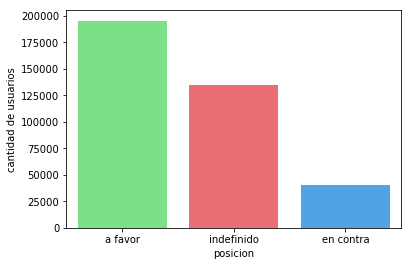

In [65]:
BLUE = '#35A7FF'
RED = '#FF5964'
GREEN = '#6BF178'

palette = {'a favor':GREEN, 'indefinido':RED, 'en contra': BLUE}

sns.countplot(data=df_final_tmp01, x='posicion' , order = df_final_tmp01.posicion.value_counts().index, palette = palette)
sns.despine
plt.ylabel('cantidad de usuarios')
plt.xlabel('posicion')

In [80]:
# renombramos columnas, para dejar a la vista desde que datasets vienen
df_final = df_final_tmp01[['id','hashed_name','verified', 'created_at','followers_count','friends_count','statuses_count','favourites_count', 'tweets',  'favorite_count','real_retweet_count','q_ht_a_favor','q_ht_en_contra',  'posicion']]
df_final.columns = ['id','hashed_name' ,'verified', 'created_at', 'user_followers', 'user_friends', 'user_statuses', 'user_favourites', 'tweets_count', 'tweets_favorite_sum', 'tweets_retweet_sum', 'q_ht_a_favor','q_ht_en_contra' , 'posicion']
df_final.head(5)

,id,hashed_name,verified,created_at,user_followers,user_friends,user_statuses,user_favourites,tweets_count,tweets_favorite_sum,tweets_retweet_sum,q_ht_a_favor,q_ht_en_contra,posicion
0,19398656,d5172b6972ac058149c18f43b85b0c65,False,2009-01-23 15:38:24+00:00,427,791,50613,10199,9,1,0,5.0,0.0,a favor
1,791841268879851520,a977df035bf9ac28b4ec811a03427fd4,False,2016-10-28 03:17:25+00:00,722,178,18823,13596,1,0,0,0.0,1.0,en contra
2,2680160258,70fbe6e143195028b48a0f997d25c941,False,2014-07-25 18:07:57+00:00,1390,1107,6576,13425,1,0,0,0.0,0.0,indefinido
3,260492029,0a1b84dcf42fd3371b6d9de79c84295f,False,2011-03-04 00:15:24+00:00,631,876,3130,11690,1,2,0,1.0,0.0,a favor
4,574707030,489539e42b7ecdfee7d4caaf492891e2,False,2012-05-08 16:59:21+00:00,1174,360,25947,9978,7,0,0,4.0,0.0,a favor


## Dataset Final (df_final)
Bajamos a disco, para ser utilizado en los proximos prácticos

In [81]:
df_final.to_csv('./out/df_final.csv') 

## Word cloud
Hashtags de los tweets de Junio y Agosto

In [42]:
text  = " ".join(ht for ht in df_hashtags_temp.hashtag)

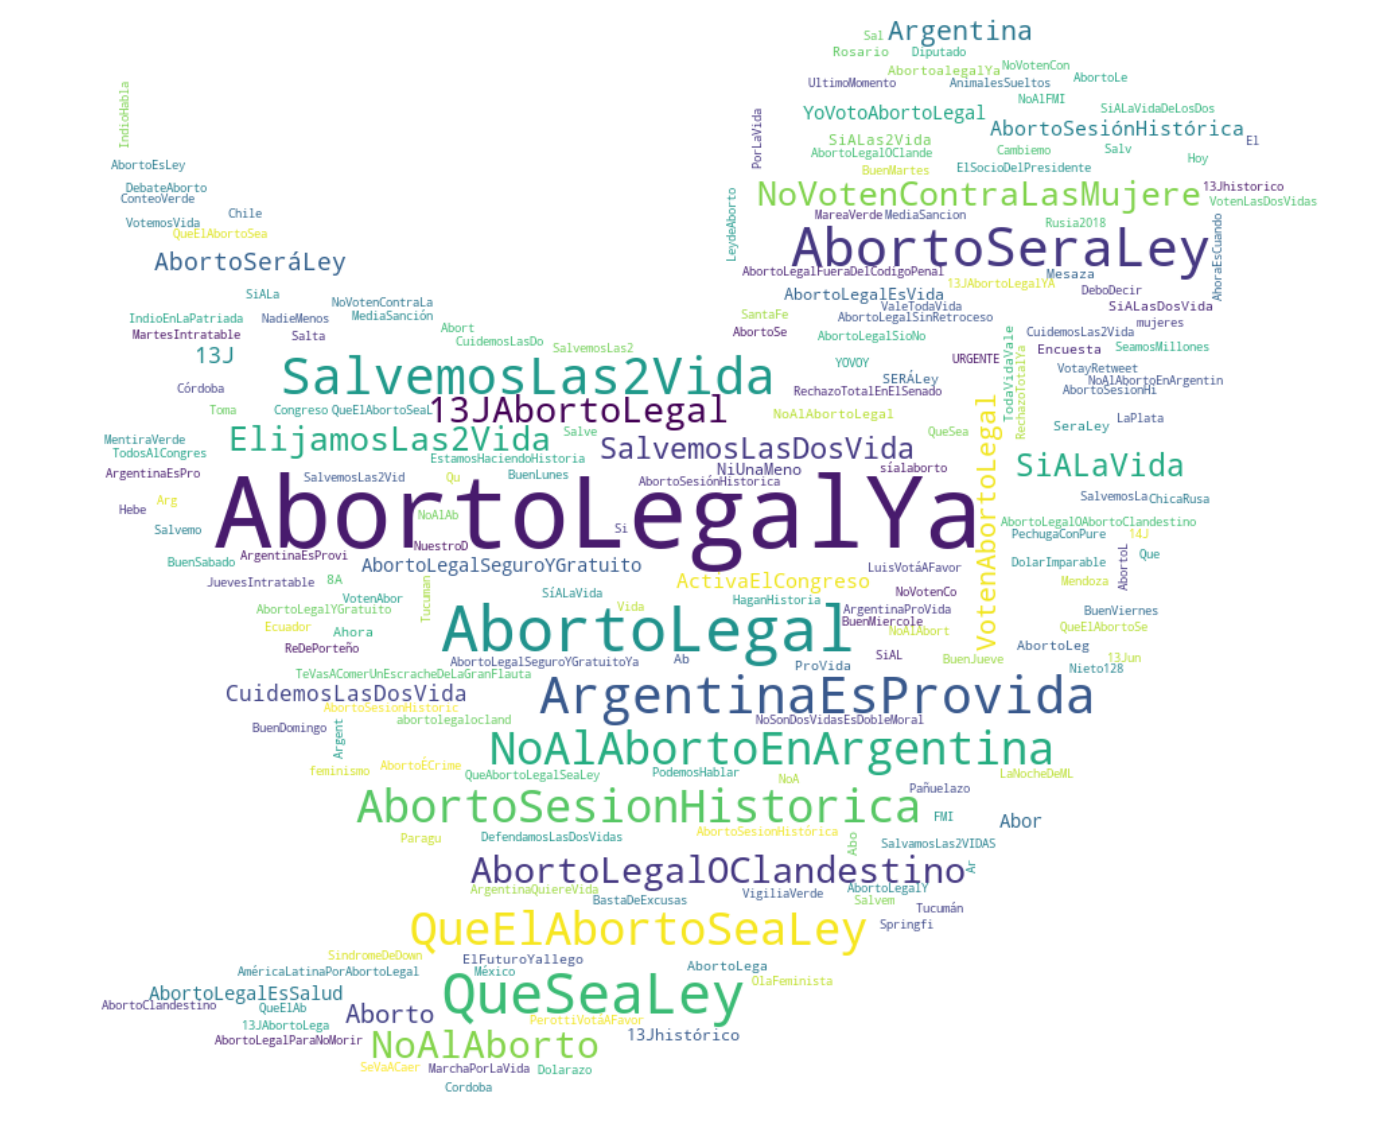

In [50]:
#from scipy.misc import imread
import imageio
twitter_mask = imageio.imread('./twitter_mask.png' ) 

# Create and generate a word cloud image:
wordcloud = WordCloud(background_color="white",mask=twitter_mask,collocations=False).generate(text)

plt.figure(figsize=(30,20))
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()